In [1]:
import os
import sys
import glob
import datetime
import warnings
from functools import partial

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


warnings.filterwarnings("ignore")

%matplotlib inline

color = (0.45, 0.57, 1)
sns.set(style="whitegrid")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('use_inf_as_na', True)

PROJECT_NAME = 'UFAL-DS'
curdir = os.path.abspath(os.path.curdir).split('/')
project_index = curdir.index(PROJECT_NAME)
os.chdir('/' + os.path.join(*curdir[:project_index + 1]))

In [2]:
cols_dict = {
    'Denominação do órgão de atuação' : 'agency', 
    'Val' : 'value', 'UF da Residência' : 'state',
    'Denominação unidade organizacional' : 'unit', 
    'Nível de Escolaridade' : 'educational_level', 
    'Quantidade de anos no Serviço público' : 'years',
    'Quantidade de meses no Serviço público' : 'months',
    'Descrição do cargo emprego' : 'role', 'CPF' : 'cpf',
    'UF da UPAG de vinculação' : 'upag_state', 'Nome' : 'name',
    'Situação servidor' : 'status', 'Cidade da residência' : 'city',
    'Ano/Mês inicial do abono de permanência' : 'allowance_start_date',
}

cat_cols = [
    'name', 'role', 'educational_level', 'agency', 
    'upag_state', 'unit', 'state', 'city', 'status',
]

num_cols = [
    'years', 'months'
]

In [3]:
def sanitize(df: DataFrame) -> DataFrame:
    df = df.rename(columns=cols_dict)
    
    df['value'] = df['value'].str.replace(',', '.').astype(float)
    df['allowance_start_date'] = pd.to_datetime(
        df['allowance_start_date'], format='%Y%m'
    )
    
    for col in cat_cols:
        df[col] = df[col].str.lower()
    
    return df


def read_data(directory:str = "data/raw/abono/*.csv") -> DataFrame:
    df = pd.concat(
        [
            pd.read_csv(file, encoding="ISO-8859-1", sep=';') 
            for file in glob.glob(directory)
        ],
        ignore_index=False
    )
    
    df = df.reset_index()
    new_columns = list(df.columns[1:]) + ["NaN"]
    cols = {
        old:new for old, new in zip(df.columns, new_columns)
    }
    
    df.rename(columns=cols, inplace=True)
    df.drop("NaN", axis=1, inplace=True)
    
    df = sanitize(df)
    
    return df

In [4]:
dataset = read_data()
dataset.head()

,name,cpf,role,educational_level,agency,upag_state,unit,state,city,status,years,months,allowance_start_date,value
0,dalva galvao pinho ...,***311601**,datilografo,ensino medio,"minist.da agricultura,pecuaria e abast.",df,coord geral adm de pessoas,df,brasilia,ativo permanente,51,9,2004-05-01,576.69
1,cicero joaquim dos santos filho ...,***204574**,auditor fiscal federal agropecuario,ensino superior,"minist.da agricultura,pecuaria e abast.",pe,sup fed agric pec abast est pernambuco,pe,caruaru,ativo permanente,43,4,2003-12-01,2241.38
2,paulo elisio de faria ...,***402121**,agente administrativo,ensino superior,"minist.da agricultura,pecuaria e abast.",df,coord geral adm de pessoas,df,brasília,ativo permanente,41,3,2010-01-01,558.32
3,maria vanilda dos santos ...,***184061**,agente administrativo,ensino medio,"minist.da agricultura,pecuaria e abast.",df,coord geral adm de pessoas,df,brasilia,ativo permanente,41,1,2009-04-01,550.73
4,sonia candida batista ...,***086171**,contador,ensino superior,"minist.da agricultura,pecuaria e abast.",df,coord geral adm de pessoas,df,brasilia,cedido,41,0,2009-09-01,1070.10


In [5]:
dataset.dtypes

name                            object
cpf                             object
role                            object
educational_level               object
agency                          object
upag_state                      object
unit                            object
state                           object
city                            object
status                          object
years                            int64
months                           int64
allowance_start_date    datetime64[ns]
value                          float64
dtype: object

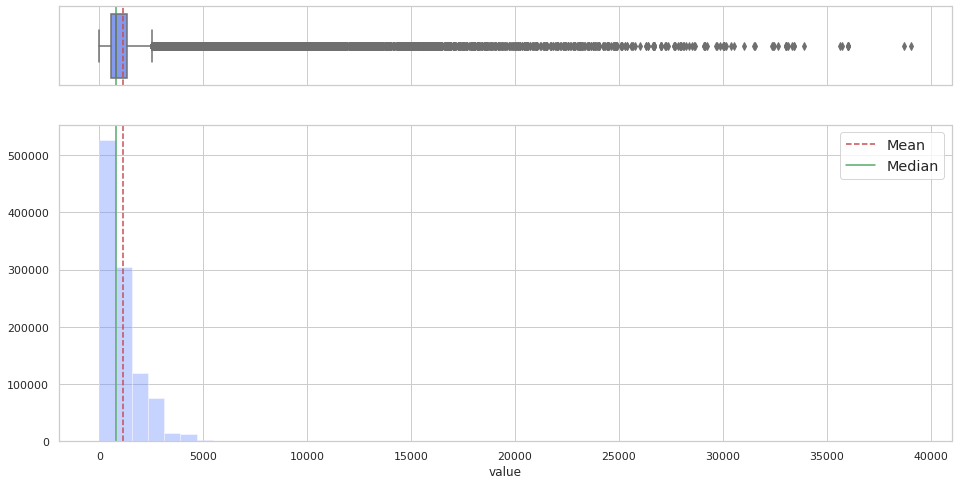

In [10]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 1)}, figsize=(16,8))
mean = dataset.value.mean()
median = dataset.value.median()

_ = sns.boxplot(dataset.value, ax=ax_box,  color=color, showfliers=True)
_ = ax_box.axvline(mean, color='r', linestyle='--')
_ = ax_box.axvline(median, color='g', linestyle='-')
_ = ax_box.set(xlabel='')

_ = sns.distplot(dataset.value, ax=ax_hist, color=color, kde=False)
_ = ax_hist.axvline(mean, color='r', linestyle='--')
_ = ax_hist.axvline(median, color='g', linestyle='-')
_ = ax_hist.xaxis.set_major_locator(ticker.MultipleLocator(5000))

_ = plt.legend({'Mean':mean,'Median':median}, fontsize='large')

In [11]:
dataset["role"].value_counts()

agente administrativo                       101491
professor do magisterio superior             88938
tecnico do seguro social                     50386
agente de saude publica                      42216
assistente em administracao                  41281
auxiliar de enfermagem                       37381
datilografo                                  27088
agente de portaria                           25375
professor ens basico tecn tecnologico        24620
aux operac servicos diversos                 21066
auditor-fiscal da receita federal brasil     20391
motorista oficial                            18570
medico                                       17476
agente de vigilancia                         14130
aux em administracao                         12193
analista tributario rec federal brasil       10719
vigilante                                    10570
aux operac de serv diversos                  10284
guarda de endemias                            9709
aux operac serv diversos       

In [6]:
dataset.loc[dataset.role.str.contains("medico"), "role_gp"] = "medico"
dataset.loc[dataset.role.str.contains("psicologo"), "role_gp"] = "medico"
dataset.loc[dataset.role.str.contains("odont"), "role_gp"] = "medico"
dataset.loc[dataset.role.str.contains("tecnico"), "role_gp"] = "tecnico"
dataset.loc[dataset.role.str.contains("tec"), "role_gp"] = "tecnico"
dataset.loc[dataset.role.str.contains("professor"), "role_gp"] = "professor"
dataset.loc[dataset.role.str.contains("agente"), "role_gp"] = "agente"
dataset.loc[dataset.role.str.contains("ag "), "role_gp"] = "agente"
dataset.loc[dataset.role.str.contains("aux"), "role_gp"] = "auxiliar"
dataset.loc[dataset.role.str.contains("analista"), "role_gp"] = "analista"
dataset.loc[dataset.role.str.contains("assistente"), "role_gp"] = "assistente"
dataset.loc[dataset.role.str.contains("operador"), "role_gp"] = "operador"
dataset.loc[dataset.role.str.contains("policia"), "role_gp"] = "policia"
dataset.loc[dataset.role.str.contains("engenhe"), "role_gp"] = "engenheiro"
dataset.loc[dataset.role.str.contains("especialista"), "role_gp"] = "especialista"
dataset.loc[dataset.role.str.contains("servente"), "role_gp"] = "servente"
dataset.loc[dataset.role.str.contains("auditor"), "role_gp"] = "auditor"
dataset.loc[dataset.role.str.contains("administrador"), "role_gp"] = "administrador"
dataset.loc[dataset.role.str.contains("motorista"), "role_gp"] = "motorista"
dataset.loc[dataset.role.str.contains("datilografo"), "role_gp"] = "datilografo" 

dataset.loc[dataset.role_gp.isna(), "role_gp"] = "outros" 

In [8]:
dataset['role_gp'].value_counts()

agente           225257
tecnico          167143
outros           155036
auxiliar         136532
professor        118947
assistente        72914
medico            32646
auditor           31127
datilografo       27268
analista          25710
motorista         25060
policia           11384
engenheiro         9543
administrador      8703
servente           5849
operador           4005
especialista       1451
Name: role_gp, dtype: int64

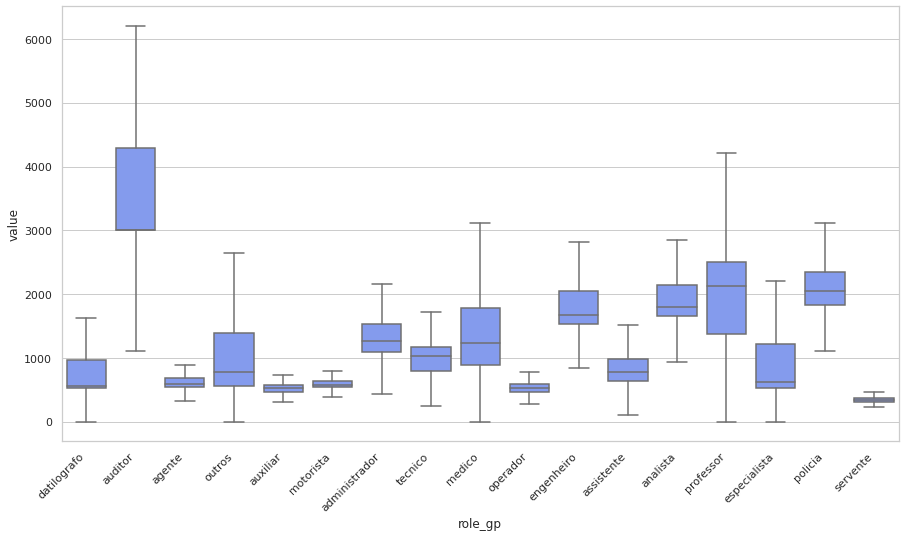

In [13]:
plt.figure(figsize=(15,8))

chart = sns.boxplot(
    x="role_gp", y="value", 
    data=dataset, color=color, showfliers=False
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

We can exploit some of these distributions in another analyzes

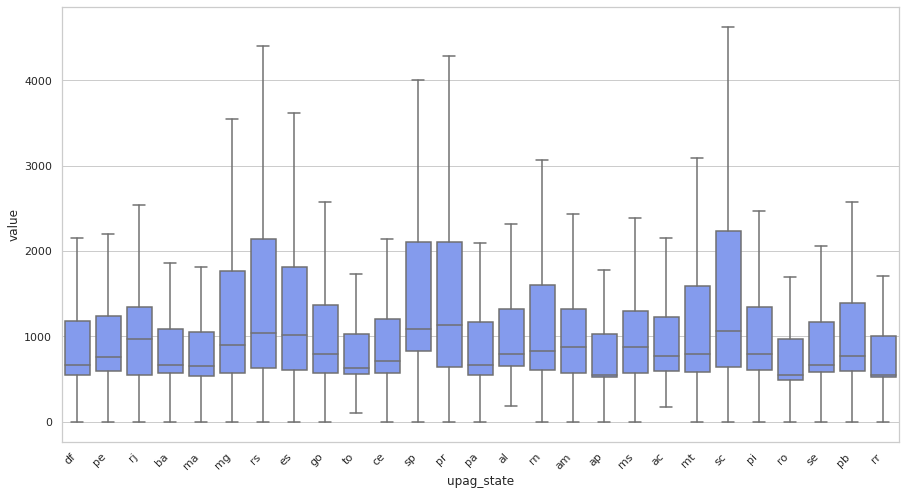

In [14]:
plt.figure(figsize=(15,8))

chart = sns.boxplot(
    x="upag_state", y="value", 
    data=dataset, color=color, showfliers=False
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

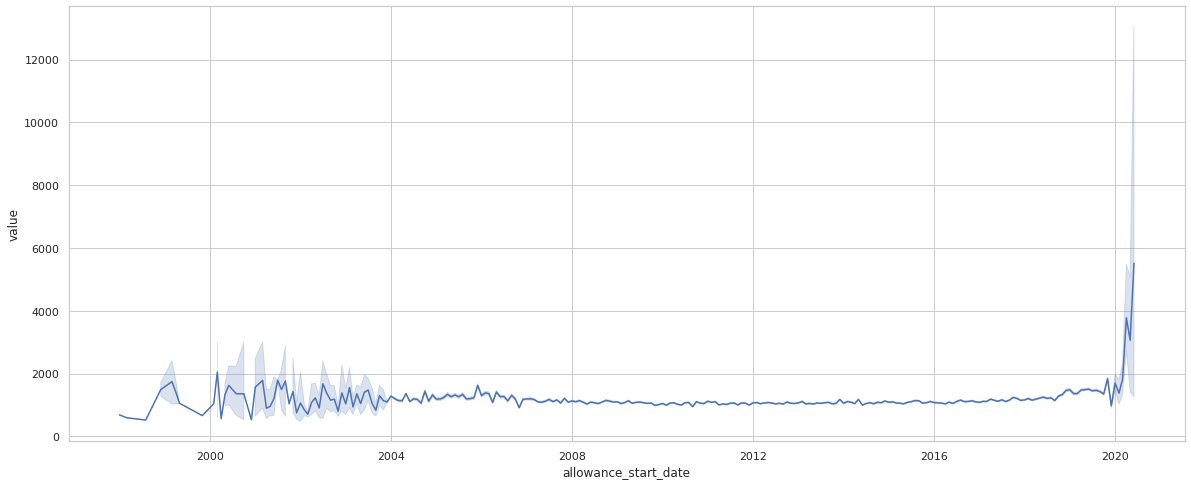

In [15]:
plt.figure(figsize=(20,8))
_ = sns.lineplot(x="allowance_start_date", y="value", data=dataset)

Perhaps split the plot by roles would tell us more about the appreciation/devaluation of some professions ...? worth a try

In [16]:
dataset.loc[
    (dataset.educational_level == '4a. serie do primeiro grau completa          ') |
    (dataset.educational_level == 'ensino fundamental incompleto                ') |
    (dataset.educational_level == 'primeiro grau incomp.-ate a 4a.serie incomp. '),
    "educational_level"
] = "1º grau incompleto"

dataset.loc[
    dataset.educational_level == 'segundo grau incompleto                      ',
    "educational_level"
] = "2º grau incompleto"

dataset.loc[
    dataset.educational_level == 'alfabetizado sem cursos regulares            ',
    "educational_level"
] = "alfabetizado"


dataset["educational_level"] = dataset["educational_level"].str.rstrip()

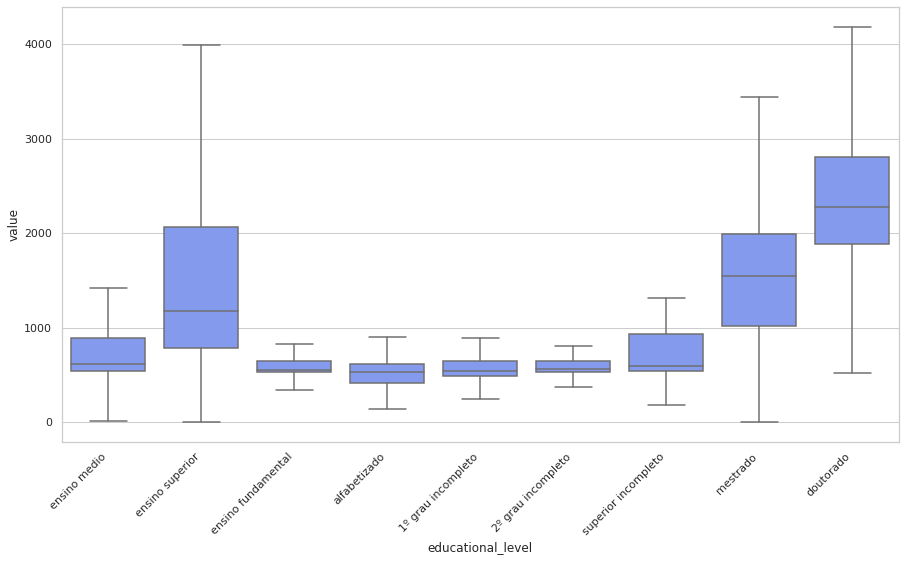

In [17]:
plt.figure(figsize=(15,8))

chart = sns.boxplot(
    x="educational_level", y="value", 
    data=dataset, color=color, showfliers=False
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

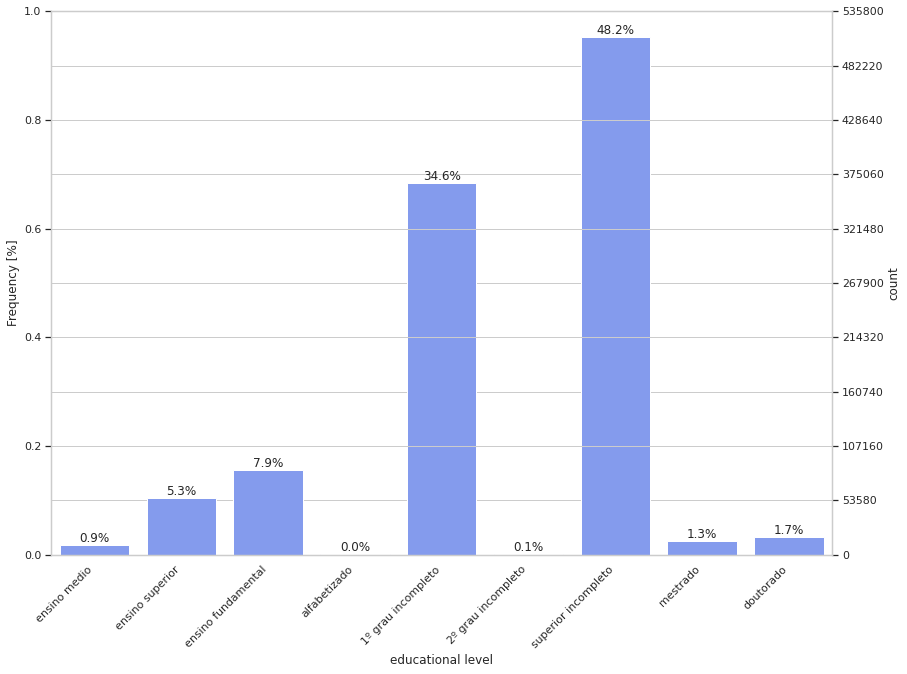

In [18]:
ncount = dataset.shape[0]

plt.figure(figsize=(14,10))

order = [
    'alfabetizado', '1º grau incompleto', 'ensino fundamental',
    '2º grau incompleto', 'ensino medio', 'superior incompleto',
    'ensino superior',  'mestrado', 'doutorado'
]

ax = sns.countplot(
    x="educational_level", data=dataset, 
    color=color, order=order
)
plt.xlabel('educational level')

ax2=ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') 

ax.yaxis.set_major_locator(ticker.LinearLocator(11))

_ = ax.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

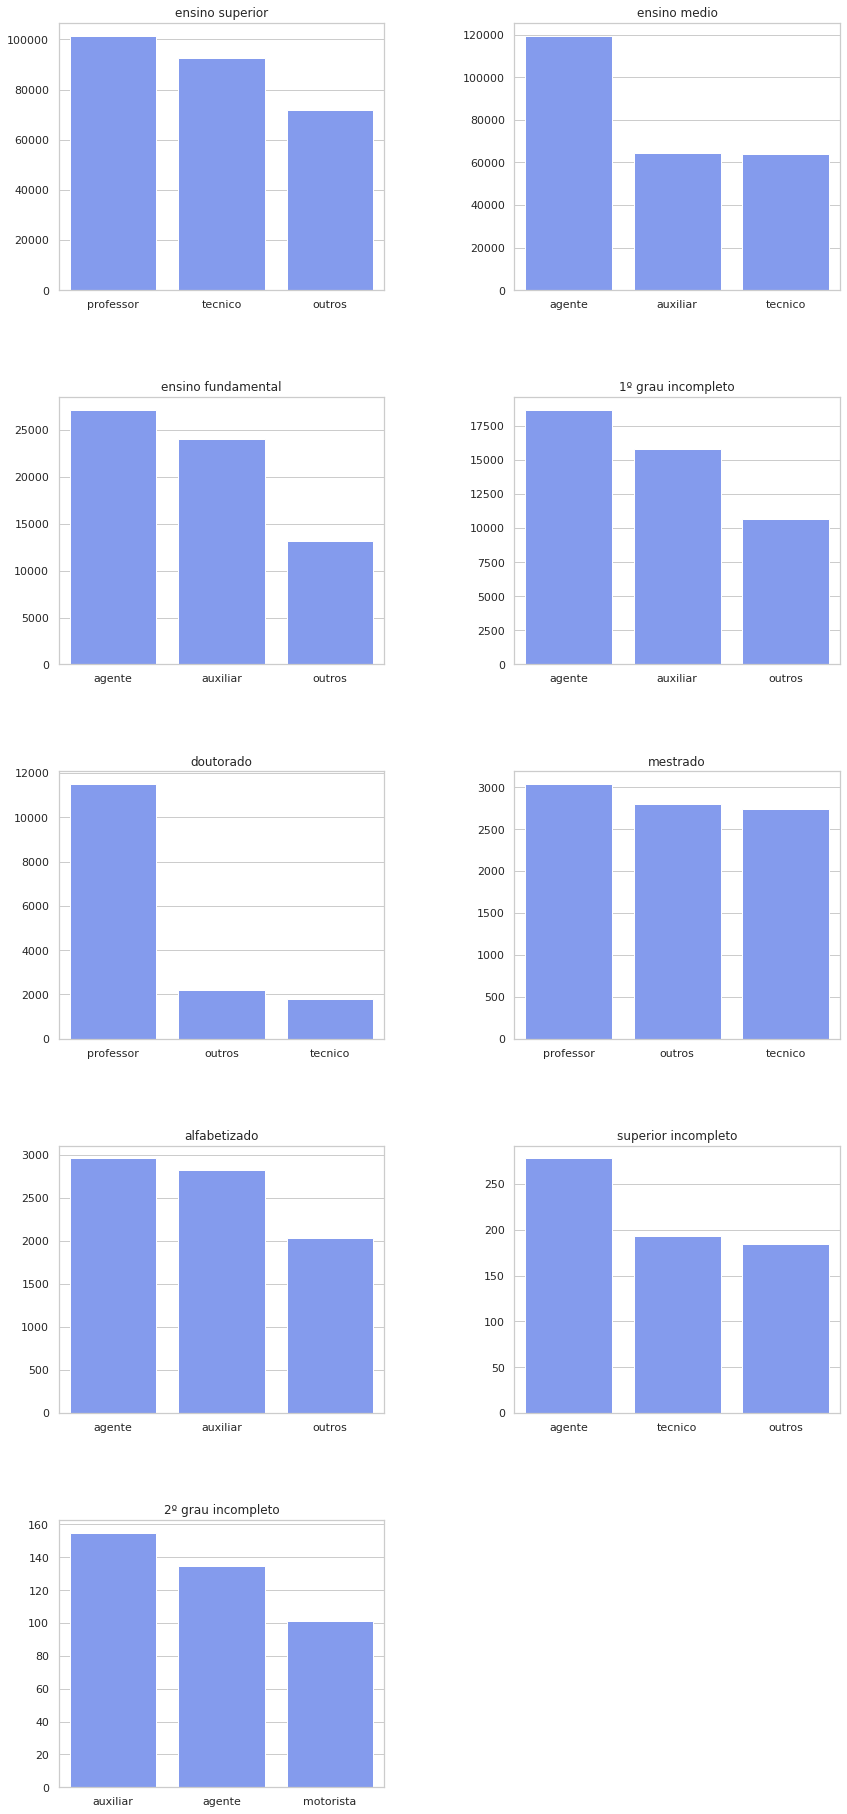

In [19]:
gp = dataset.groupby('educational_level')
levels = dataset.educational_level.value_counts()

fig = plt.figure(figsize=(14,60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

total_plots = levels.shape[0]
i = 0
for level in levels.keys():
    ax = fig.add_subplot(total_plots, 2, i+1)
    ax.set_title(level)
    
    top = gp.get_group(level)["role_gp"].value_counts()[:3]
    _ = sns.barplot(x=top.keys(), y=top.values, color=color, ax=ax)
    
    i += 1